In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


## Libraries

In [2]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords

## Data Loading

In [3]:
tweetds = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
tweetds.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
tweetds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [5]:
tweetds.describe(include='all')

,id,keyword,location,text,target
count,11370.000000,11370,7952,11370,11370.000000
unique,NaN,219,4504,11223,NaN
top,NaN,thunderstorm,United States,I want to help you with my project to save the...,NaN
freq,NaN,93,96,3,NaN
mean,5684.500000,NaN,NaN,NaN,0.185928
std,3282.380615,NaN,NaN,NaN,0.389066
min,0.000000,NaN,NaN,NaN,0.000000
25%,2842.250000,NaN,NaN,NaN,0.000000
50%,5684.500000,NaN,NaN,NaN,0.000000
75%,8526.750000,NaN,NaN,NaN,0.000000


## Data Cleaning

In [6]:
# stopwords
try:
  stop_words = set(stopwords.words("english"))
except:
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))

# remove the stopwords and single-character words
def remove_sw_and_sc(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words and len(i) > 1:
            final_text.append(i.strip())
    return " ".join(final_text)

In [7]:
# clean text function
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub('https?://\S+', '', text) # remove url
    text = re.sub('<.*?>', '', text) # remove html tags
    text = re.sub('&\S+?;', '', text) # remove html entities
    text = re.sub(r'@\S+', '', text) # remove mention
    text = re.sub('[^\w\s]+', '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\d+', '', text) # remove numbers
    # text = stemmer.stem(text) # stemming
    text = text.strip() # remove whitespace
    return text

# source https://www.kaggle.com/code/masatoshikato/effective-eda-bert-in-nlp-bert-baseline
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)

In [8]:
X, y = tweetds['text'], tweetds['target']

X = X.apply(clean_text)
X = X.apply(lambda text: remove_emoji(text))
X = X.apply(remove_sw_and_sc)

In [9]:
X.sample(5).values

array(['going place zombie apocalypse happens',
       'bantz moronic twat probably follows didnt happen account nice guy fragile ego narci',
       'hazardous air level due bushfires australia makes impossible continue match',
       'girlfriend want spend rest life kim jongdae',
       'lsd subreddit screaming rn'], dtype=object)

## EDA

In [10]:
tweet_desc = tweetds[['text', 'target']]
tweet_desc.text.sample(10).values

array(['E7F03BA0 :Battle ID I need backup! Lvl 60 Leviathan Omega https://t.co/dWXWxOz2re',
       'stay friends? to plant a small garden on the cooled lava of dying feelings? no, this is not for you and me. this happens on…',
       'Nsukka ppl have finally sunk lower... This pit seems to have no end.. Chukwu nna 😂😂😂😂😂😂 help them',
       'The little girl suffered a brain hemorrhage from a nonaccidental traumatic head injury. https://t.co/ezQgMOYhZo',
       'Crews are planning to build a bridge for cyclists and pedestrians near the trail. https://t.co/Fp4Yrp33L1',
       'Trump is simply a political arsonist. He requires crisis and chaos to survive. If there is no crisis, he…',
       "The nuclear deal hasn't collapsed in January 2020. It was *destroyed* by Donald Trump in May 2018. #FakeNews",
       'the world is watching, and heating and burning, please don’t subsidise #Flybe. We need to #FlyLess and… https://t.co/KDOI7AI3GE',
       '👉🏻Confession Time Always had a soft corner for

In [11]:
# Hashtag
tweet_desc['hashtags'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Mention
tweet_desc['mention'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.startswith('@')]))

# Punctuation
def count_punct(text):
    # transform a html entity to count as a symbol
    text = re.sub('&\S+?;', '&', text)
    # count punctuation
    count = sum([1 for char in text if char in string.punctuation])
    return count

tweet_desc['punctuation'] = tweet_desc['text'].apply(lambda x: count_punct(x))
# hashtags and mentions don't count as punctuation
tweet_desc['punctuation'] -= tweet_desc['hashtags'] + tweet_desc['mention']

# Numbers / Digits
tweet_desc['numerics'] = tweet_desc['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

# di bawah ini, symbol, html tags & entities, dan url terhitung juga? kalau gak cleaning dulu

# Number of Words
tweet_desc['word_count'] = tweet_desc['text'].apply(lambda x: len(str(x).split(" ")))

# Number of Character
tweet_desc['char_count'] = tweet_desc['text'].str.len()

tweet_desc.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,target,hashtags,mention,punctuation,numerics,word_count,char_count
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1,0,0,4,0,19,125
1,Telangana: Section 144 has been imposed in Bha...,1,0,0,3,2,23,131
2,Arsonist sets cars ablaze at dealership https:...,1,0,0,5,0,7,63
3,Arsonist sets cars ablaze at dealership https:...,1,0,0,10,0,8,87
4,"""Lord Jesus, your love brings freedom and pard...",0,0,0,8,0,23,140


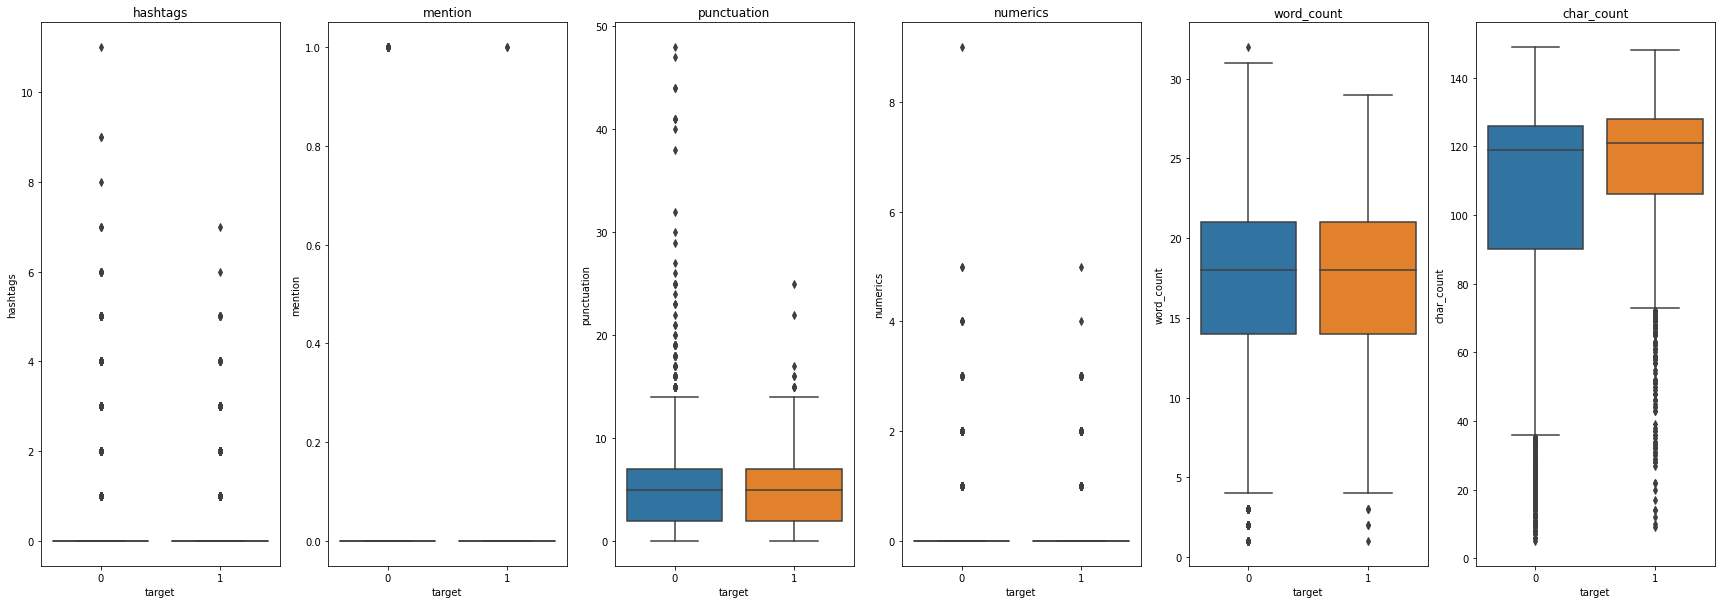

In [12]:
# boxplot
num_columns = tweet_desc.columns[2:]

plt.figure(figsize=(30, 10))
for ind, col in enumerate(num_columns):
    plt.subplot(1, 6, ind+1)
    sns.boxplot(data=tweet_desc, y=col, x='target')
    plt.title(col)
plt.show()

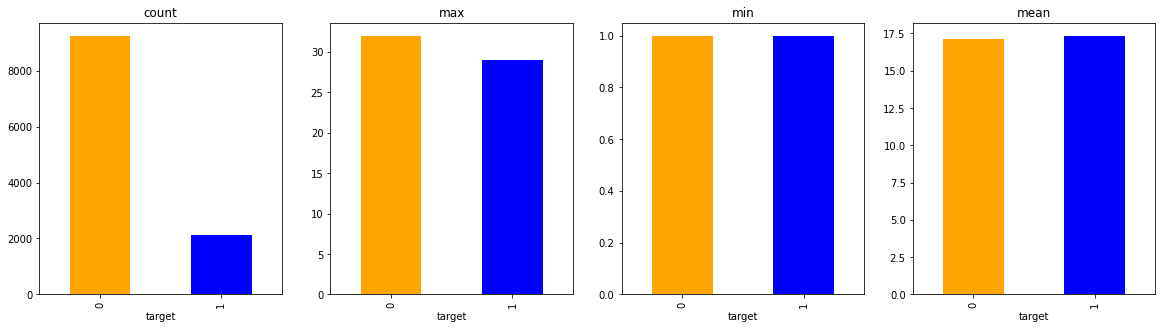

In [13]:
# word count stats
stats = tweet_desc.groupby(['target']).agg(['count', 'max', 'min', 'mean']).word_count.T

plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    stats.iloc[i].plot.bar(color=['orange', 'blue'])
    plt.title(stats.iloc[i].name)
plt.show()

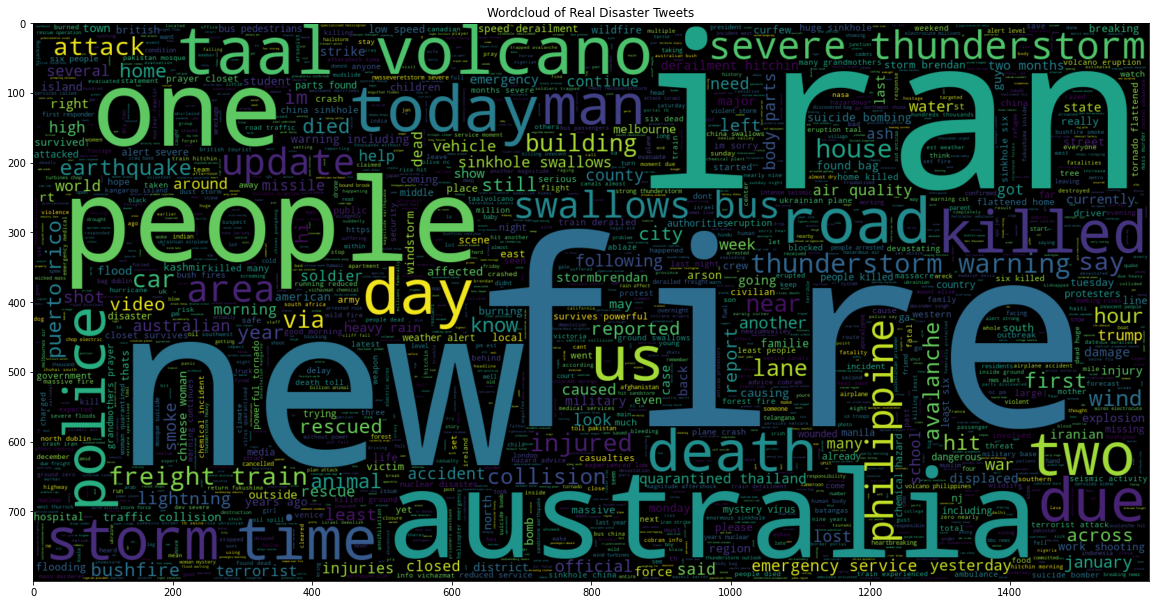

In [14]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 1]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Real Disaster Tweets")
plt.show()

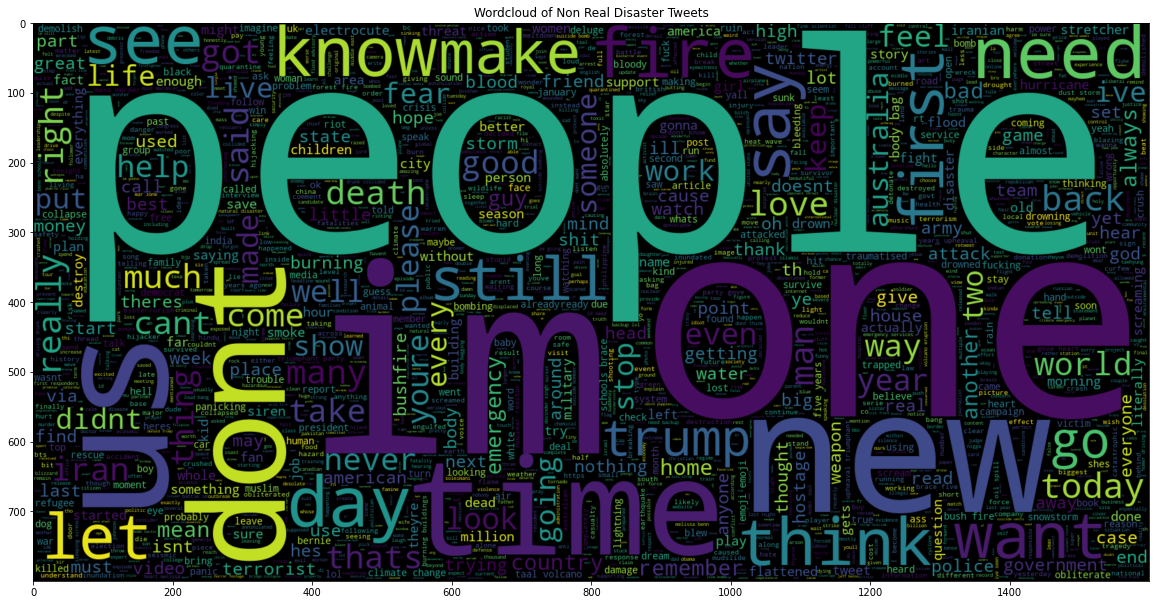

In [15]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(" ".join(X[y == 0]))
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Wordcloud of Non Real Disaster Tweets")
plt.show()

In [16]:
# tokenzation
# n grams
# stem and lemma